In [63]:
import numpy as np
import pandas as pd

In [64]:
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
from plot_learning_curve import plot_learning_curve

# Config

In [101]:
random_state = 1291

feature_cols = ["PC", "RA", "SA1","FiringRate_value","Spikes_n_items",  "depth","Pin_Radius","duration",
                "Spikes_diff_time_inrange_10",
                "Spikes_diff_time_inrange_20", 
                "Spikes_diff_mean_5",
                "Spikes_diff_mean_15"] # "depth", "Pin_Radius"

target_col = "Frequency"

N_folds = 10

# Load Data

In [102]:
dataset = pd.read_csv("../data/dataset_v3.csv", index_col=0).reset_index(drop=True)

In [103]:
print(dataset.shape)
dataset.sample(5)

(42343, 13)


,PC,RA,SA1,FiringRate_value,Spikes_n_items,depth,Pin_Radius,duration,Spikes_diff_time_inrange_10,Spikes_diff_time_inrange_20,Spikes_diff_mean_5,Spikes_diff_mean_15,Frequency
2787,1,0,0,55.00000,88,1.79,0.79,1.6000,0.179199,0.181763,0.090837,0.272603,55
36857,0,1,0,31.59375,58,1.67,1.14,1.8360,0.307129,0.307617,0.153726,0.461304,65
28559,1,0,0,144.00000,173,1.52,0.67,1.2020,0.086975,0.066589,0.033775,0.100453,75
38517,0,1,0,82.87500,120,0.71,0.69,1.4485,0.129883,0.117432,0.059049,0.176704,85
1469,1,0,0,43.68750,69,0.90,1.38,1.5800,0.222046,0.222168,0.111068,0.333249,45


# Split

In [104]:
X, y = dataset[feature_cols], dataset[target_col]
X.shape, y.shape

((42343, 12), (42343,))

In [105]:
print(f"Using N_folds: {N_folds}")
skf = StratifiedKFold(n_splits=N_folds, shuffle=True, random_state=random_state)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    dataset[f"fold_{i}"] = ""
    dataset.loc[train_index, f"fold_{i}"] = "train"
    dataset.loc[test_index, f"fold_{i}"] = "test"

Using N_folds: 10


# Model

In [106]:
# BaggingClassifier - ElasticNetCV

# enet = ElasticNetCV(
#     l1_ratio=0.5,
#     eps=0.001,
#     n_alphas=100,
#     random_state=random_state,
#     fit_intercept=True)

# bagging = BaggingRegressor(enet,
#                            n_estimators=100,
#                             max_samples=0.5, max_features=0.5)


In [107]:
# RandomForestClassifier

rfc = RandomForestClassifier(
    min_samples_split=6,
    max_features=0.3,
    n_jobs=2,
) 


# rfc = RandomForestRegressor(
#     min_samples_split=2 # 25
# ) 

In [108]:
# ElasticNetCV

# enet = ElasticNetCV(
#     l1_ratio=0.5,
#     eps=0.001,
#     n_alphas=100,
#     random_state=random_state,
#     fit_intercept=True)

In [116]:
%%time

for f in range(N_folds):
    print(f"fold_{f}")
    X_tr, y_tr = dataset.loc[dataset[f"fold_{f}"]=="train",feature_cols], dataset.loc[dataset[f"fold_{f}"]=="train", target_col]
    X_test, y_test = dataset.loc[dataset[f"fold_{f}"]=="test",feature_cols], dataset.loc[dataset[f"fold_{f}"]=="test", target_col]
    
    rfc = rfc.fit(X_tr, y_tr)
    print(
        rfc.score(X_tr, y_tr),
        rfc.score(X_test, y_test)
    )
    
    dataset.loc[dataset[f"fold_{f}"]=="train", f"fold_{f}_pred"] = rfc.predict(X_tr)
    dataset.loc[dataset[f"fold_{f}"]=="test", f"fold_{f}_pred"] = rfc.predict(X_test)
    
    

fold_0
0.979059515062454 0.867060212514758
fold_1
0.9788495853888948 0.8651711924439197
fold_2
0.9783772436233862 0.8531286894923259
fold_3
0.97782676008292 0.8665564478034955
fold_4
0.9791125455929046 0.8644307982994804
fold_5
0.9790338240310688 0.8646669815777043
fold_6
0.978561494660054 0.8658478979688238
fold_7
0.9788763809073971 0.8670288143599433
fold_8
0.9796111154845312 0.865139348134152
fold_9
0.9792699887165761 0.865375531412376
CPU times: user 3min 44s, sys: 7.02 s, total: 3min 51s
Wall time: 2min 7s


In [117]:
import joblib
joblib.dump(rfc, '../models/rfc_v3.joblib') 

['../models/rfc_v3.joblib']

# Learning Curve - model - data dependancy

CPU times: user 76.6 ms, sys: 7.98 ms, total: 84.5 ms
Wall time: 1min 9s


<module 'matplotlib.pyplot' from '/home/minesh_1291/anaconda3/envs/noaa-runtime/lib/python3.8/site-packages/matplotlib/pyplot.py'>

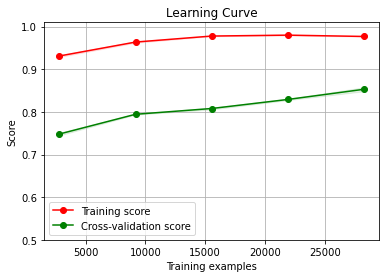

In [115]:
%%time

rfc = RandomForestClassifier(
    min_samples_split=12,
    max_features=0.7,
    n_jobs=2,
) 
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)


plot_learning_curve(estimator=rfc, title="Learning Curve", X=X, y=y, ylim=(0.5, 1.01), cv=skf, n_jobs=2)

# Check Data Distribution to specific fold

In [111]:
for f in range(N_folds):
    X_tr, y_tr = dataset.loc[dataset[f"fold_{f}"]=="train",feature_cols], dataset.loc[dataset[f"fold_{f}"]=="train", target_col]
    X_test, y_test = dataset.loc[dataset[f"fold_{f}"]=="test",feature_cols], dataset.loc[dataset[f"fold_{f}"]=="test", target_col]
    
    y_counts = pd.concat([
        y_tr.value_counts().rename("train"), 
        X_tr["PC RA SA1".split()].groupby(y_tr).sum(),
        y_test.value_counts().rename("test"),
        X_test["PC RA SA1".split()].groupby(y_test).sum()],1
    )
    
    print(f"fold_{f}")
    print(y_counts)
    print()

fold_0
    train    PC    RA  SA1  test   PC   RA  SA1
5     290     9   281    0    33    2   31    0
15   2138  1289   849    0   237  133  104    0
25   3310  2080  1230    0   367  234  133    0
35   3907  2472  1435    0   434  291  143    0
45   4352  2643  1709    0   484  310  174    0
55   4573  2795  1778    0   508  293  215    0
65   4777  2902  1875    0   531  310  221    0
75   4918  2900  2018    0   547  304  242    1
85   4956  2967  1988    1   551  326  225    0
95   4887  2958  1929    0   543  330  213    0

fold_1
    train    PC    RA  SA1  test   PC   RA  SA1
5     290    11   279    0    33    0   33    0
15   2138  1275   863    0   237  147   90    0
25   3310  2082  1228    0   367  232  135    0
35   3907  2499  1408    0   434  264  170    0
45   4352  2660  1692    0   484  293  191    0
55   4573  2778  1795    0   508  310  198    0
65   4777  2903  1874    0   531  309  222    0
75   4918  2884  2033    1   547  320  227    0
85   4956  2968  1987    

In [113]:
dataset["Afferent_Class"] = dataset[["PC", "RA", "SA1"]].idxmax(1)

In [114]:
dataset.groupby(["Afferent_Class","Frequency"])["fold_1"].value_counts().sort_index()

Afferent_Class  Frequency  fold_1
PC              5          train       11
                15         test       147
                           train     1275
                25         test       232
                           train     2082
                35         test       264
                           train     2499
                45         test       293
                           train     2660
                55         test       310
                           train     2778
                65         test       309
                           train     2903
                75         test       320
                           train     2884
                85         test       325
                           train     2968
                95         test       329
                           train     2959
RA              5          test        33
                           train      279
                15         test        90
                           train      863
